In [1]:
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib.slim.python.slim.nets.inception_v3 import inception_v3
slim = tf.contrib.slim

In [2]:
IMAGE_URI = "1241696720_a7988ab4d3.jpg"
INCEPTION_URI = "inception_v3.ckpt"
VOCAB_URI = "names.txt"

NUM_STEPS = 1000
NUM_LOGS = 10
ORIGINAL_IDX = 282
TARGET_IDX = 0

batch_norm_params = {
    "is_training": False,
    "trainable": False,
    # Decay for the moving averages.
    "decay": 0.9997,
    # Epsilon to prevent 0s in variance.
    "epsilon": 0.001,
    # Collection containing the moving mean and moving variance.
    "variables_collections": {
        "beta": None,
        "gamma": None,
        "moving_mean": ["moving_vars"],
        "moving_variance": ["moving_vars"],
    }
}

In [3]:
with open(VOCAB_URI, "r") as f:
    class_to_name = {}
    for line in f:
        (key, val) = line.strip().split(":")
        class_to_name[int(key)] = val

In [4]:
graph = tf.Graph()
session = tf.Session(graph=graph)

In [5]:
with tf.gfile.GFile(IMAGE_URI, "rb") as f:
    image_bytes = f.read()

In [6]:
with graph.as_default():
    
    image_tensor = tf.cast(tf.expand_dims(
        tf.image.decode_jpeg(
            image_bytes, channels=3), axis=0), tf.float32) / 256.0
    image_tensor = tf.image.resize_image_with_crop_or_pad(
        image_tensor, 300, 300)
    
    image_variable = tf.Variable(
        image_tensor)
    offset_variable = (image_variable - image_tensor) * 0.5 + 0.5
    global_step = tf.Variable(
        0, name="global_step", trainable=False)
    init_op = tf.variables_initializer([image_variable, global_step])
    
    with tf.variable_scope(
            "InceptionV3", "InceptionV3") as scope:
        
        with slim.arg_scope(
                [slim.conv2d, slim.fully_connected],
                trainable=False,
                weights_regularizer=None):
            
            with slim.arg_scope(
                    [slim.conv2d],
                    weights_initializer=tf.truncated_normal_initializer(
                        stddev=0.1),
                    activation_fn=tf.nn.relu,
                    normalizer_fn=slim.batch_norm,
                    normalizer_params=batch_norm_params):
                
                logits, end_points = inception_v3(
                    image_variable * 2.0 - 1.0, scope=scope, 
                    num_classes=1001)
                probs = tf.nn.softmax(logits)
                inception_variables = tf.get_collection(
                    tf.GraphKeys.GLOBAL_VARIABLES, scope="InceptionV3")
                
    loss = -tf.log(tf.reshape(probs, [-1])[TARGET_IDX] * (
        1.0 - tf.reshape(probs, [-1])[ORIGINAL_IDX]))
    learning_rate = tf.train.exponential_decay(
        1.0, global_step,
        100, 0.5)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    gradients = optimizer.compute_gradients(
        loss, var_list=[image_variable])
    
    apply = optimizer.apply_gradients(gradients)
    clip = tf.assign(
        image_variable, 
        tf.clip_by_value(image_variable, 0.0, 1.0))

In [7]:
session.run(init_op)
saver = tf.train.Saver(inception_variables)
saver.restore(session, INCEPTION_URI)

INFO:tensorflow:Restoring parameters from inception_v3.ckpt


Iter: 0 Probs[282]: 0.82735 Probs[0]: 0.00002 Pred[282]: 0.82735 = 'tiger cat'
Iter: 111 Probs[282]: 0.00038 Probs[0]: 0.12525 Pred[0]: 0.12525 = 'tench, Tinca tinca'
Iter: 222 Probs[282]: 0.00097 Probs[0]: 0.22075 Pred[0]: 0.22075 = 'tench, Tinca tinca'
Iter: 333 Probs[282]: 0.00167 Probs[0]: 0.43213 Pred[0]: 0.43213 = 'tench, Tinca tinca'
Iter: 444 Probs[282]: 0.00054 Probs[0]: 0.25453 Pred[0]: 0.25453 = 'tench, Tinca tinca'
Iter: 555 Probs[282]: 0.00120 Probs[0]: 0.67380 Pred[0]: 0.67380 = 'tench, Tinca tinca'
Iter: 666 Probs[282]: 0.00003 Probs[0]: 0.67522 Pred[0]: 0.67522 = 'tench, Tinca tinca'
Iter: 777 Probs[282]: 0.00001 Probs[0]: 0.56997 Pred[0]: 0.56997 = 'tench, Tinca tinca'
Iter: 888 Probs[282]: 0.00003 Probs[0]: 0.62584 Pred[0]: 0.62584 = 'tench, Tinca tinca'
Iter: 999 Probs[282]: 0.00052 Probs[0]: 0.70331 Pred[0]: 0.70331 = 'tench, Tinca tinca'


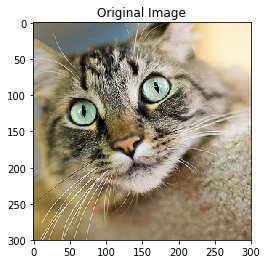

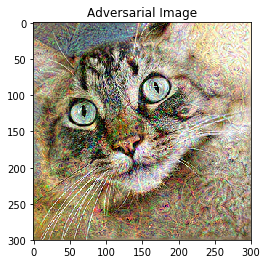

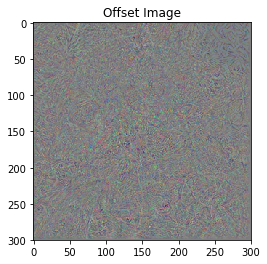

In [8]:
for i in range(NUM_STEPS):
    
    results = session.run(probs)
    session.run(apply)
    session.run(clip)
    img = session.run(image_variable)
    
    results = results.flatten()
    idx = np.argmax(results)
    
    if i % ((NUM_STEPS - 1) // (max(NUM_LOGS, 2) - 1)) == 0:
    
        print("Iter: %d" % i,
              "Probs[%d]: %.5f" % (ORIGINAL_IDX, results[ORIGINAL_IDX]), 
              "Probs[%d]: %.5f" % (TARGET_IDX, results[TARGET_IDX]), 
              "Pred[%d]: %0.5f = %s" % (idx, results[idx], class_to_name[idx]))
        
original, adversarial, offset = session.run([
    image_tensor, image_variable, offset_variable])

plt.imshow(original[0, :, :, :])
plt.title("Original Image")
plt.show()
plt.close()

plt.imshow(adversarial[0, :, :, :])
plt.title("Adversarial Image")
plt.show()
plt.close()

plt.imshow(offset[0, :, :, :])
plt.title("Offset Image")
plt.show()
plt.close()